In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

In [2]:
logfile='log-clean.csv'
df = pd.read_csv(logfile)

In [3]:
df.head()
#len(df)
#df.dtypes
#df.columns.values

,f_mains,f_mains_syncd,f_clk_syncd,clk_accuracy_ppm,t_wallclock,t_wallclock_str
0,49.9820,49.9810,41999205,19,1663595612501951690,2022-09-19 13:53:32
1,49.9864,49.9854,41999205,19,1663595612501951690,2022-09-19 13:53:32
2,49.9830,49.9820,41999205,19,1663595612501951690,2022-09-19 13:53:32
3,49.9779,49.9769,41999205,19,1663595612501951690,2022-09-19 13:53:32
4,49.9876,49.9867,41999205,19,1663595612501951690,2022-09-19 13:53:32


In [4]:
# Suppress phase shift events by taking the median over 5 samples. 
# A phase shift event is defined as a single long period immediately 
# followed by a single short period.
df_f = df.f_mains_syncd
df_f_clean = df_f.groupby(np.arange(len(df_f))//5).median()

f_min = df_f_clean.min()
f_max = df_f_clean.max()
f_mean = np.mean(df_f_clean)
f_std = np.std(df_f_clean)
f_sem = stats.sem(df_f_clean)

# 95 % confidence interval of the mean.
# Here "scale" is not the std. dev. (sigma) as usual, 
# but the standard error of the mean (sem = sigma/sqrt(n)) 
f_mean_l,f_mean_h = stats.norm.interval(0.95, loc=f_mean, scale=f_sem)

f_error = df_f_clean - 50.0
f_mse = np.mean(np.square(f_error))

print("min(f) = " + str(f_min) + " Hz")
print("max(f) = " + str(f_max) + " Hz")
print("mean(f) = " + str(f_mean) + " Hz")
print("mean_conf95(f) = [" + str(f_mean_l) + "," + str(f_mean_h) + "]")
print("mse(f) = " + str(f_mse))

min(f) = 49.8985 Hz
max(f) = 50.084 Hz
mean(f) = 49.99746010472713 Hz
mean_conf95(f) = [49.99743707491953,49.99748313453473]
mse(f) = 0.0004523008169940214


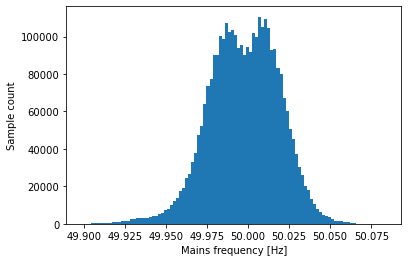

In [5]:
bin_sizes, _, _ = plt.hist(df_f_clean, bins=100)
plt.ylabel('Sample count')
plt.xlabel('Mains frequency [Hz]');

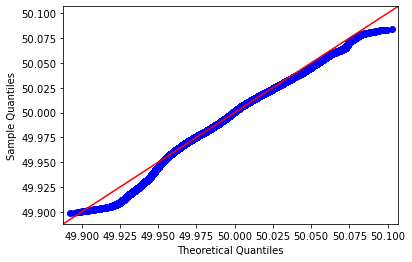

In [6]:
qqplot = sm.qqplot(df_f_clean, loc=f_mean, scale=f_std, line="45")
plt.show()

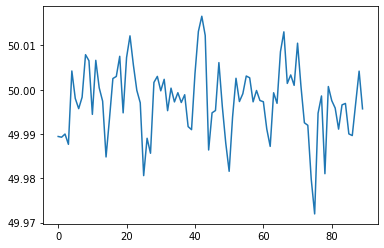

In [7]:
df_f = df_f_clean
# Downsampling
# Note: df_f_clean has 50/5 samples per second due to taking the median over 5 samples 
# for phase-shift event removal (see above).
df_f_ds = df_f.groupby(np.arange(len(df_f))//(50/5*3600)).mean()
_ = df_f_ds.plot(y='f_mains_syncd', use_index=True)

In [8]:
# The regular interval for mains frequency is [49.8 Hz,50.2 Hz]. 
# Any frequency outside this interval is abnormal, e.g., a phase-shift event 
# (single pair of outliers; non-critical) or a long-term deviation (critical).
df_selected = df.loc[(df.f_mains_syncd > 50.2) | (df.f_mains_syncd < 49.8)]
df_selected.head()

,f_mains,f_mains_syncd,f_clk_syncd,clk_accuracy_ppm,t_wallclock,t_wallclock_str
9402544,50.2517,50.2509,41999295,17,1663783672537745292,2022-09-21 18:07:52
9402545,49.6986,49.6977,41999295,17,1663783672537745292,2022-09-21 18:07:52
14318189,50.3344,50.3335,41999300,17,1663881991749198417,2022-09-22 21:26:31
14318190,49.6748,49.6740,41999300,17,1663881991749198417,2022-09-22 21:26:31


In [9]:
fclk_min = df.f_clk_syncd.min()
fclk_max = df.f_clk_syncd.max()
fclk_mean = np.mean(df.f_clk_syncd)
fclk_std = np.std(df.f_clk_syncd)
fclk_sem = stats.sem(df.f_clk_syncd)

# 95 % confidence interval
fclkmean_l,fclkmean_h = stats.norm.interval(0.95, loc=fclk_mean, scale=fclk_sem)

print("min(f) = " + str(fclk_min) + " Hz")
print("max(f) = " + str(fclk_max) + " Hz")
print("mean(f) = " + str(fclk_mean) + " Hz" + "\t\t95% conf. int. = [" + str(fclkmean_l) + "," + str(fclkmean_h) + "]")

min(f) = 41998753 Hz
max(f) = 42000406 Hz
mean(f) = 41999294.67595137 Hz		95% conf. int. = [41999294.66405772,41999294.68784502]


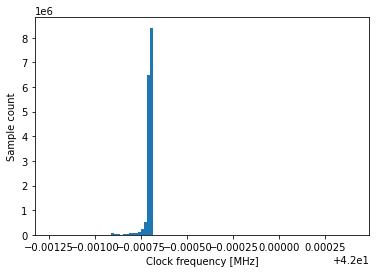

In [10]:
bin_sizes, _, _ = plt.hist(df.f_clk_syncd/1000000, bins=100)
plt.ylabel('Sample count')
plt.xlabel('Clock frequency [MHz]');

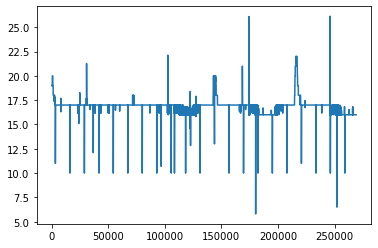

In [11]:
df_acc = df.clk_accuracy_ppm
# Downsample by calculating mean value for each minute (60 samples)
df_acc_ds = df_acc.groupby(np.arange(len(df_acc))//60).mean()
_ = df_acc_ds.plot(y='clk_accuracy_ppm', use_index=True)